Import some used libraries. In this notebook we will use some basic Python libraries, including pandas, numpy, etc. Among them, matplotlib, plotly, seaborn are used for data visualization; math and scipy for statistics; and scikit-learn for PCA.

In [39]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import math
from scipy.stats import ttest_ind, wilcoxon, ttest_rel, entropy

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

We have worked on Google Colab, so need to mount drive. Remove this cell if you run on local computer.

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Change the root to your project directory to run this notebook.

In [41]:
root = '/content/drive/My Drive/DS_World Happiness'
data_path = os.path.join(root, 'data/data_completed.csv')

# **1. Overview of the Data**

Let's read the data. After cleaning, there are 148 records and 16 variables in our data. Among varibles, Happiness index is the response, it is numeric continous and ranges from 0 to 10. The others are explanatory varibles, Regional indicator is categorical nominal and the rest are numeric continous.

In [42]:
data = pd.read_csv(data_path)
print("Number of rows:", data.shape[0])
print("Number of columns:", data.shape[1])
data

Number of rows: 149
Number of columns: 17


,Country,Regional Indicator,Population density (people per sq. km of land area),GDP per capita (current US$),"Unemployment, total (% of labour force)",Consumer price index (2010 = 100),Mean years of schooling (years),Life expectancy at birth (years),Healthy life expectancy (HALE) at birth (years),Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%),Age-standardized suicide rates (per 100 000 population),Gender Development Index (GDI),"Person held per 100,000 population","Carbon dioxide emissions, production emissions per capita (tonnes)","PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)",Forest area (% of land area),Happiness Index
0,Afghanistan,South Asia,56.933998,498.842544,11.119667,147.343066,3.880000,64.482000,53.94961,10.590000,5.940000,0.660000,82.718353,0.2505,56.910808,1.850994,2.5669
1,Albania,Central and Eastern Europe,104.550170,5071.447533,12.807000,117.167089,10.085333,78.453667,69.07545,5.135000,3.923333,0.967333,185.418472,1.5990,18.200603,28.792001,4.8827
2,Algeria,Middle East and North Africa,17.728018,4080.461684,11.860667,147.403289,7.980333,76.690667,66.38806,6.300000,2.573333,0.859667,148.376871,3.6225,38.884011,0.813411,5.0051
3,Argentina,Latin America and Caribbean,16.257843,12154.946384,9.118667,141.821140,10.690333,76.520667,67.12776,10.040000,8.606667,0.992667,206.361994,4.4750,13.311834,10.520130,5.9747
4,Armenia,Commonwealth of Independent States,103.667697,4246.571500,17.397000,126.907196,11.302000,74.944000,67.11749,10.195000,2.246667,0.979333,90.645396,1.7935,32.528118,11.552160,4.6768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Venezuela,Latin America and Caribbean,32.804424,8287.383552,7.773333,141.821140,10.312333,72.144667,64.43692,4.890000,2.183333,1.013000,194.187701,5.0150,17.008554,52.543484,5.0532
145,Vietnam,Southeast Asia,308.111835,2549.081694,2.019667,158.739414,8.240000,75.319333,65.29554,5.925000,7.363333,0.998000,133.769222,2.0580,29.626728,46.735544,5.3535
146,Yemen,Middle East and North Africa,53.977446,861.205026,13.021333,160.479847,3.133333,66.104000,57.53111,6.099286,7.003333,0.486333,182.256693,0.3595,50.456007,1.039832,3.5274
147,Zambia,Sub-Saharan Africa,23.346362,1452.188659,11.517000,195.922759,7.104000,63.481000,54.40409,4.665000,15.666300,0.972000,134.680854,0.3025,27.438035,60.789702,3.7594


The following two cells are name of variables, and the names we used to displayed.

In [43]:
cols = data.columns.tolist()
explanatory_variables = cols[2:-1]
response_variable = cols[-1]

In [44]:
explanatory_name = ['Population density',
                     'GDP per capita',
                     'Unemployment rate',
                     'Consumer price index',
                     'Mean years of schooling',
                     'Life expectancy',
                     'Healthy life expectancy',
                     'Health expenditure',
                     'Suicide rate',
                     'GDI',
                     'Crime rate',
                     'CO2 emissions per capita',
                     'PM2.5',
                     'Forest area']

# **2. Explanatory Data Analysis**

## **2.1 Some basic statistics**

Below are some statistics of the numeric data. For some attributes, mean and median are different, because of the outliers, which will be visualized letter. In this situation, median is better to represents the data.

In [45]:
statistic = pd.concat([data.mean(), data.median(), data.std()], keys= ['Mean', 'Median', 'Standard deviation'], axis= 1)
statistic.T

,Population density (people per sq. km of land area),GDP per capita (current US$),"Unemployment, total (% of labour force)",Consumer price index (2010 = 100),Mean years of schooling (years),Life expectancy at birth (years),Healthy life expectancy (HALE) at birth (years),Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%),Age-standardized suicide rates (per 100 000 population),Gender Development Index (GDI),"Person held per 100,000 population","Carbon dioxide emissions, production emissions per capita (tonnes)","PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)",Forest area (% of land area),Happiness Index
Mean,262.228651,15000.407243,6.993255,213.282620,8.808526,72.669723,63.894795,6.748413,10.185505,0.937737,164.897823,4.621648,28.048008,29.151793,5.466690
Median,82.307864,5876.540348,5.238333,128.220263,9.382000,74.573333,65.460660,6.680000,8.580000,0.966667,137.118413,2.794500,21.767721,28.787209,5.510400
Standard deviation,897.344629,20584.074350,5.247346,775.203585,3.189160,7.897532,6.377583,2.520496,8.897208,0.076792,110.018144,5.309294,19.413348,20.508728,1.119538


To see some statistics of each region, we use pandas groupby function.

In [46]:
data_region = data.groupby(['Regional Indicator'])
data_region = data_region.mean()
data_region

,Population density (people per sq. km of land area),GDP per capita (current US$),"Unemployment, total (% of labour force)",Consumer price index (2010 = 100),Mean years of schooling (years),Life expectancy at birth (years),Healthy life expectancy (HALE) at birth (years),Current health expenditure (CHE) as percentage of gross domestic product (GDP) (%),Age-standardized suicide rates (per 100 000 population),Gender Development Index (GDI),"Person held per 100,000 population","Carbon dioxide emissions, production emissions per capita (tonnes)","PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)",Forest area (% of land area),Happiness Index
Regional Indicator,,,,,,,,,,,,,,,
Central and Eastern Europe,80.697834,13979.578993,8.794667,115.149230,11.704812,77.229687,67.756952,6.991875,10.790465,0.988292,154.860229,5.953656,18.207469,39.970482,5.856231
Commonwealth of Independent States,59.028141,4894.035788,7.641222,201.863714,11.461306,72.260000,64.503052,6.240833,11.079592,0.967424,249.269580,5.629250,23.256443,17.906674,5.358342
East Asia,1624.386907,26708.761275,4.031333,131.027948,11.075533,79.672400,68.991527,6.840000,14.753583,0.971733,113.422475,8.695200,32.380412,41.282300,5.566740
Latin America and Caribbean,108.184216,8287.383552,6.449651,141.821140,8.630333,74.911921,65.863193,7.238810,6.425249,0.978111,248.451495,3.621095,17.338487,41.120320,5.981786
Middle East and North Africa,260.041215,13488.124695,9.509167,160.479847,8.460688,75.382812,65.745356,6.099286,4.451458,0.872396,192.224314,8.508719,49.450177,5.242408,5.269306
North America and ANZ,15.426343,51784.072725,4.907833,114.897882,13.038667,81.650583,69.634748,11.523750,11.910767,0.980667,284.623464,14.060750,7.086038,31.857039,7.173525
South Asia,612.457662,2988.413878,5.209762,159.929916,6.280000,71.319952,61.969811,5.451429,8.314048,0.843857,107.521356,1.161214,55.077433,17.704014,4.475443
Southeast Asia,1024.021241,10871.248998,2.215000,132.543693,7.818148,73.144185,64.495561,4.279444,5.427778,0.966630,213.737565,3.177222,23.539028,44.956262,5.383367
Sub-Saharan Africa,113.875228,2015.533974,7.360000,418.580308,5.346615,62.080949,55.415073,5.778462,15.509780,0.894880,118.636531,0.801051,37.119724,28.062597,4.383495


We use histogram to count the number of countries in each regions. The distribution is quite imbalanced, the Sub-Saharan Africa region has 39 countries while there are 4 countries in North America and ANZ, 6 countries in East Asia and 7 countries in South Asia. <br> 
The first following cell is used to calculate entropy and gini index.

In [47]:
arr = []
regions = []
for region in data_region.index:
    regions.append(region)
    arr.append(len(data[data['Regional Indicator'] == region].index))

ent = entropy(arr)
max_ent = math.log(148)
gini = 1 - sum([(x/sum(arr))**2 for x in arr])
max_gini = 1 - 1/sum(arr)

This cell is for plot the histogram of regional indicator.

Entropy: 2.103 
Max entropy: 4.997 
Gini: 0.856 
Max gini: 0.993


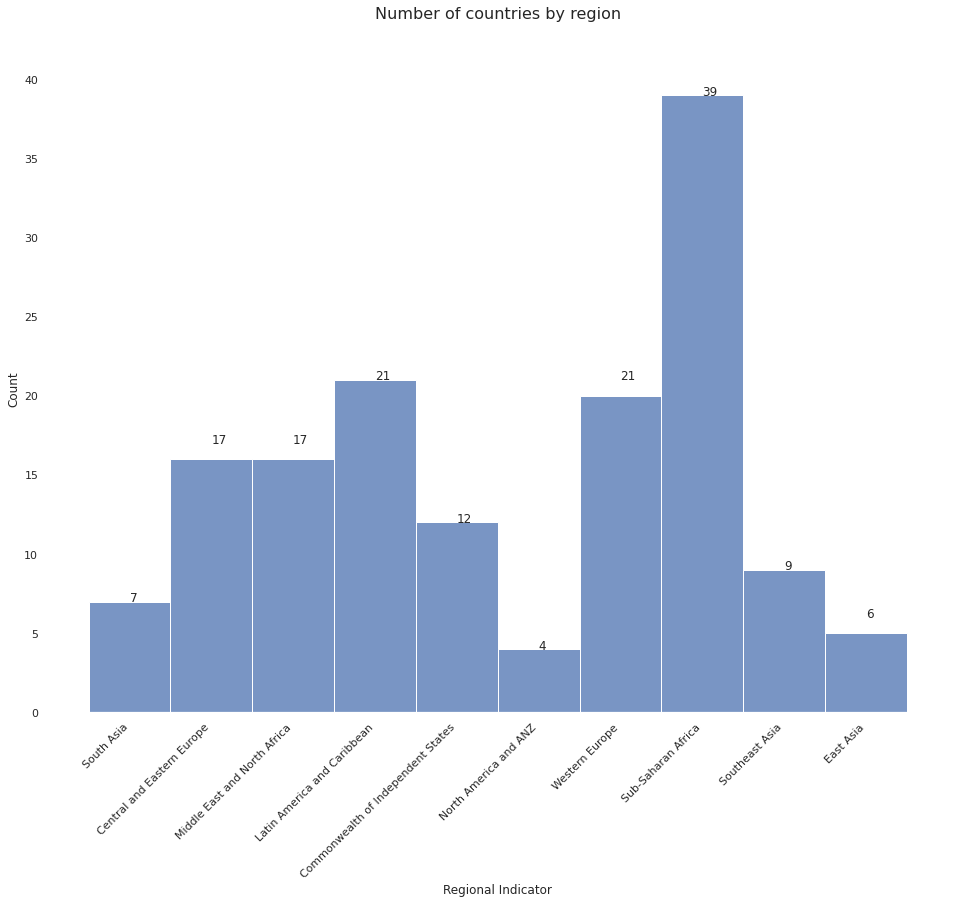

In [48]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 0.9])
ax.set_facecolor('white')

no_countries = [ 7, 17, 17, 21, 12,  4, 21, 39,  9,  6]
position = [0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]
pos = [x for x in range(10)]

arr = sns.histplot(data= data, x = "Regional Indicator", ax = ax)
for tick in ax.get_xticklabels():
  tick.set_rotation(45)
  tick.set_horizontalalignment('right')
for i in range(10):
    plt.text(i,no_countries[i],str(no_countries[i]))

fig.suptitle("Number of countries by region", size = 16)
print("Entropy:", round(ent, 3), '\nMax entropy:', round(max_ent, 3), '\nGini:', round(gini, 3), '\nMax gini:', round(max_gini, 3))
plt.show()

For the numeric variable, we use density plot to see the distribution of them. From the figure, we can deduce that median is better than mean, in GDP per capita and unemployment rate for instacne. 

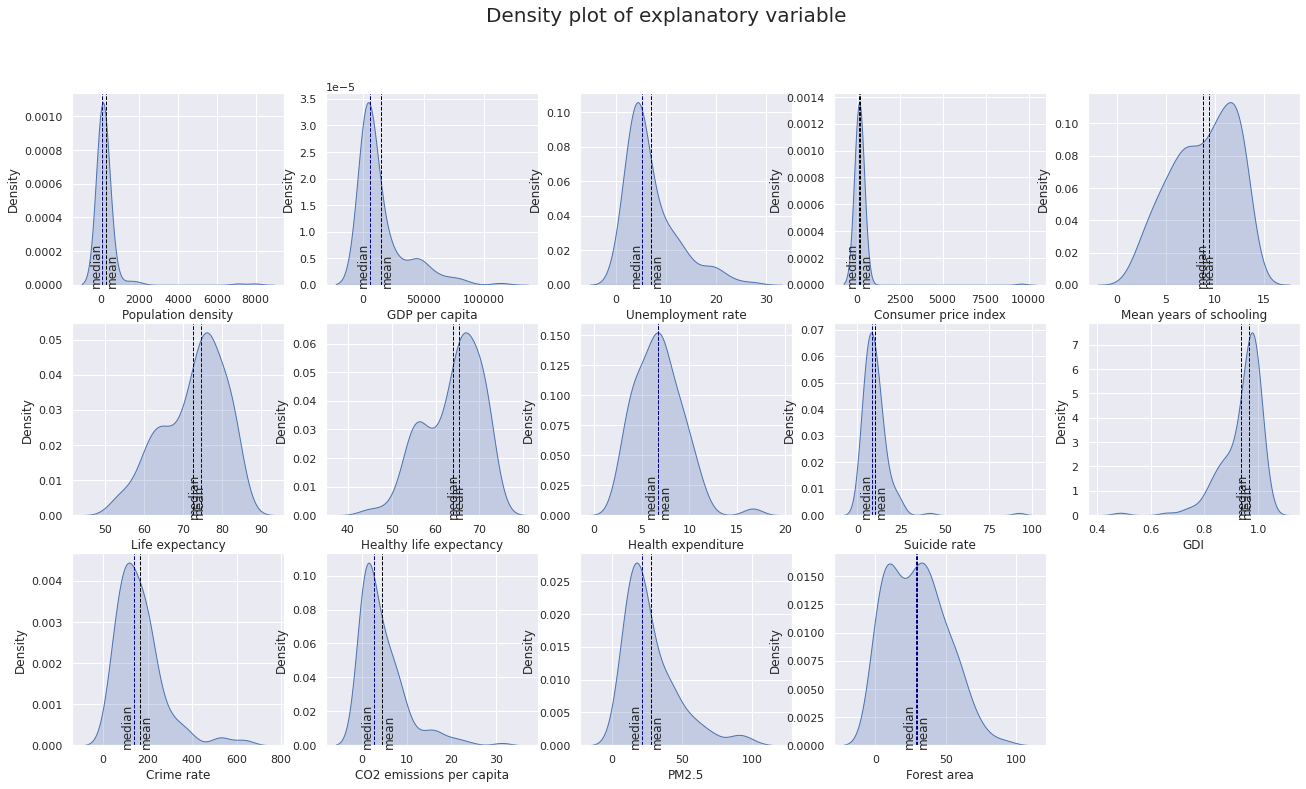

In [49]:
row = 3
column = 5
fig, axes = plt.subplots(row, column)
fig.set_size_inches(22, 12)
fig.suptitle('Density plot of explanatory variable', size= 20)

for i in range(14):
    sns.kdeplot(data[explanatory_variables[i]], ax = axes[i//column, i%column], fill = True)
    axes[i//column, i%column].axvline(x=data[explanatory_variables[i]].mean(), linewidth=1, ls='--', color='black')
    axes[i//column, i%column].text(x=data[explanatory_variables[i]].mean(), y=0, rotation=90,s='mean', ha = 'left')
    axes[i//column, i%column].axvline(x=data[explanatory_variables[i]].median(), linewidth=1, ls='--', color='darkblue')
    axes[i//column, i%column].text(x=data[explanatory_variables[i]].median(), y=0, rotation=90,s='median', ha = 'right')
    
    axes[i//column, i%column].set_xlabel(explanatory_name[i])
axes[2, 4].set_axis_off()
# axes[3, 2].set_axis_off()

plt.show()

## **2.2 Happiness in each region**

Let's see this globally.  
At a glance, we see that many of the happiest countries in the world are indeed in North America, Australia and some Western Europe countries.  
This plot confirms what we discovered above, with North America and ANZ in yellow and Sub-Saharan Africa in dark purple and blue color.

In [50]:
happiness = data[['Country', 'Happiness Index']]
fig = px.choropleth(happiness, 
                     locations="Country", 
                     locationmode = "country names",
                     color = "Happiness Index",
                     hover_name = "Country",
                     color_continuous_scale = px.colors.sequential.Plasma
                     )
fig

We see that the happiness country is Finland while the least happiness is Afghanistan. We've noted that 9 of the top 10 are in Western Europe, and that 7 of the bottom 10 are in Africa. The happiness value of the top happiness countries is above 2 times compared with the least happiness countries.

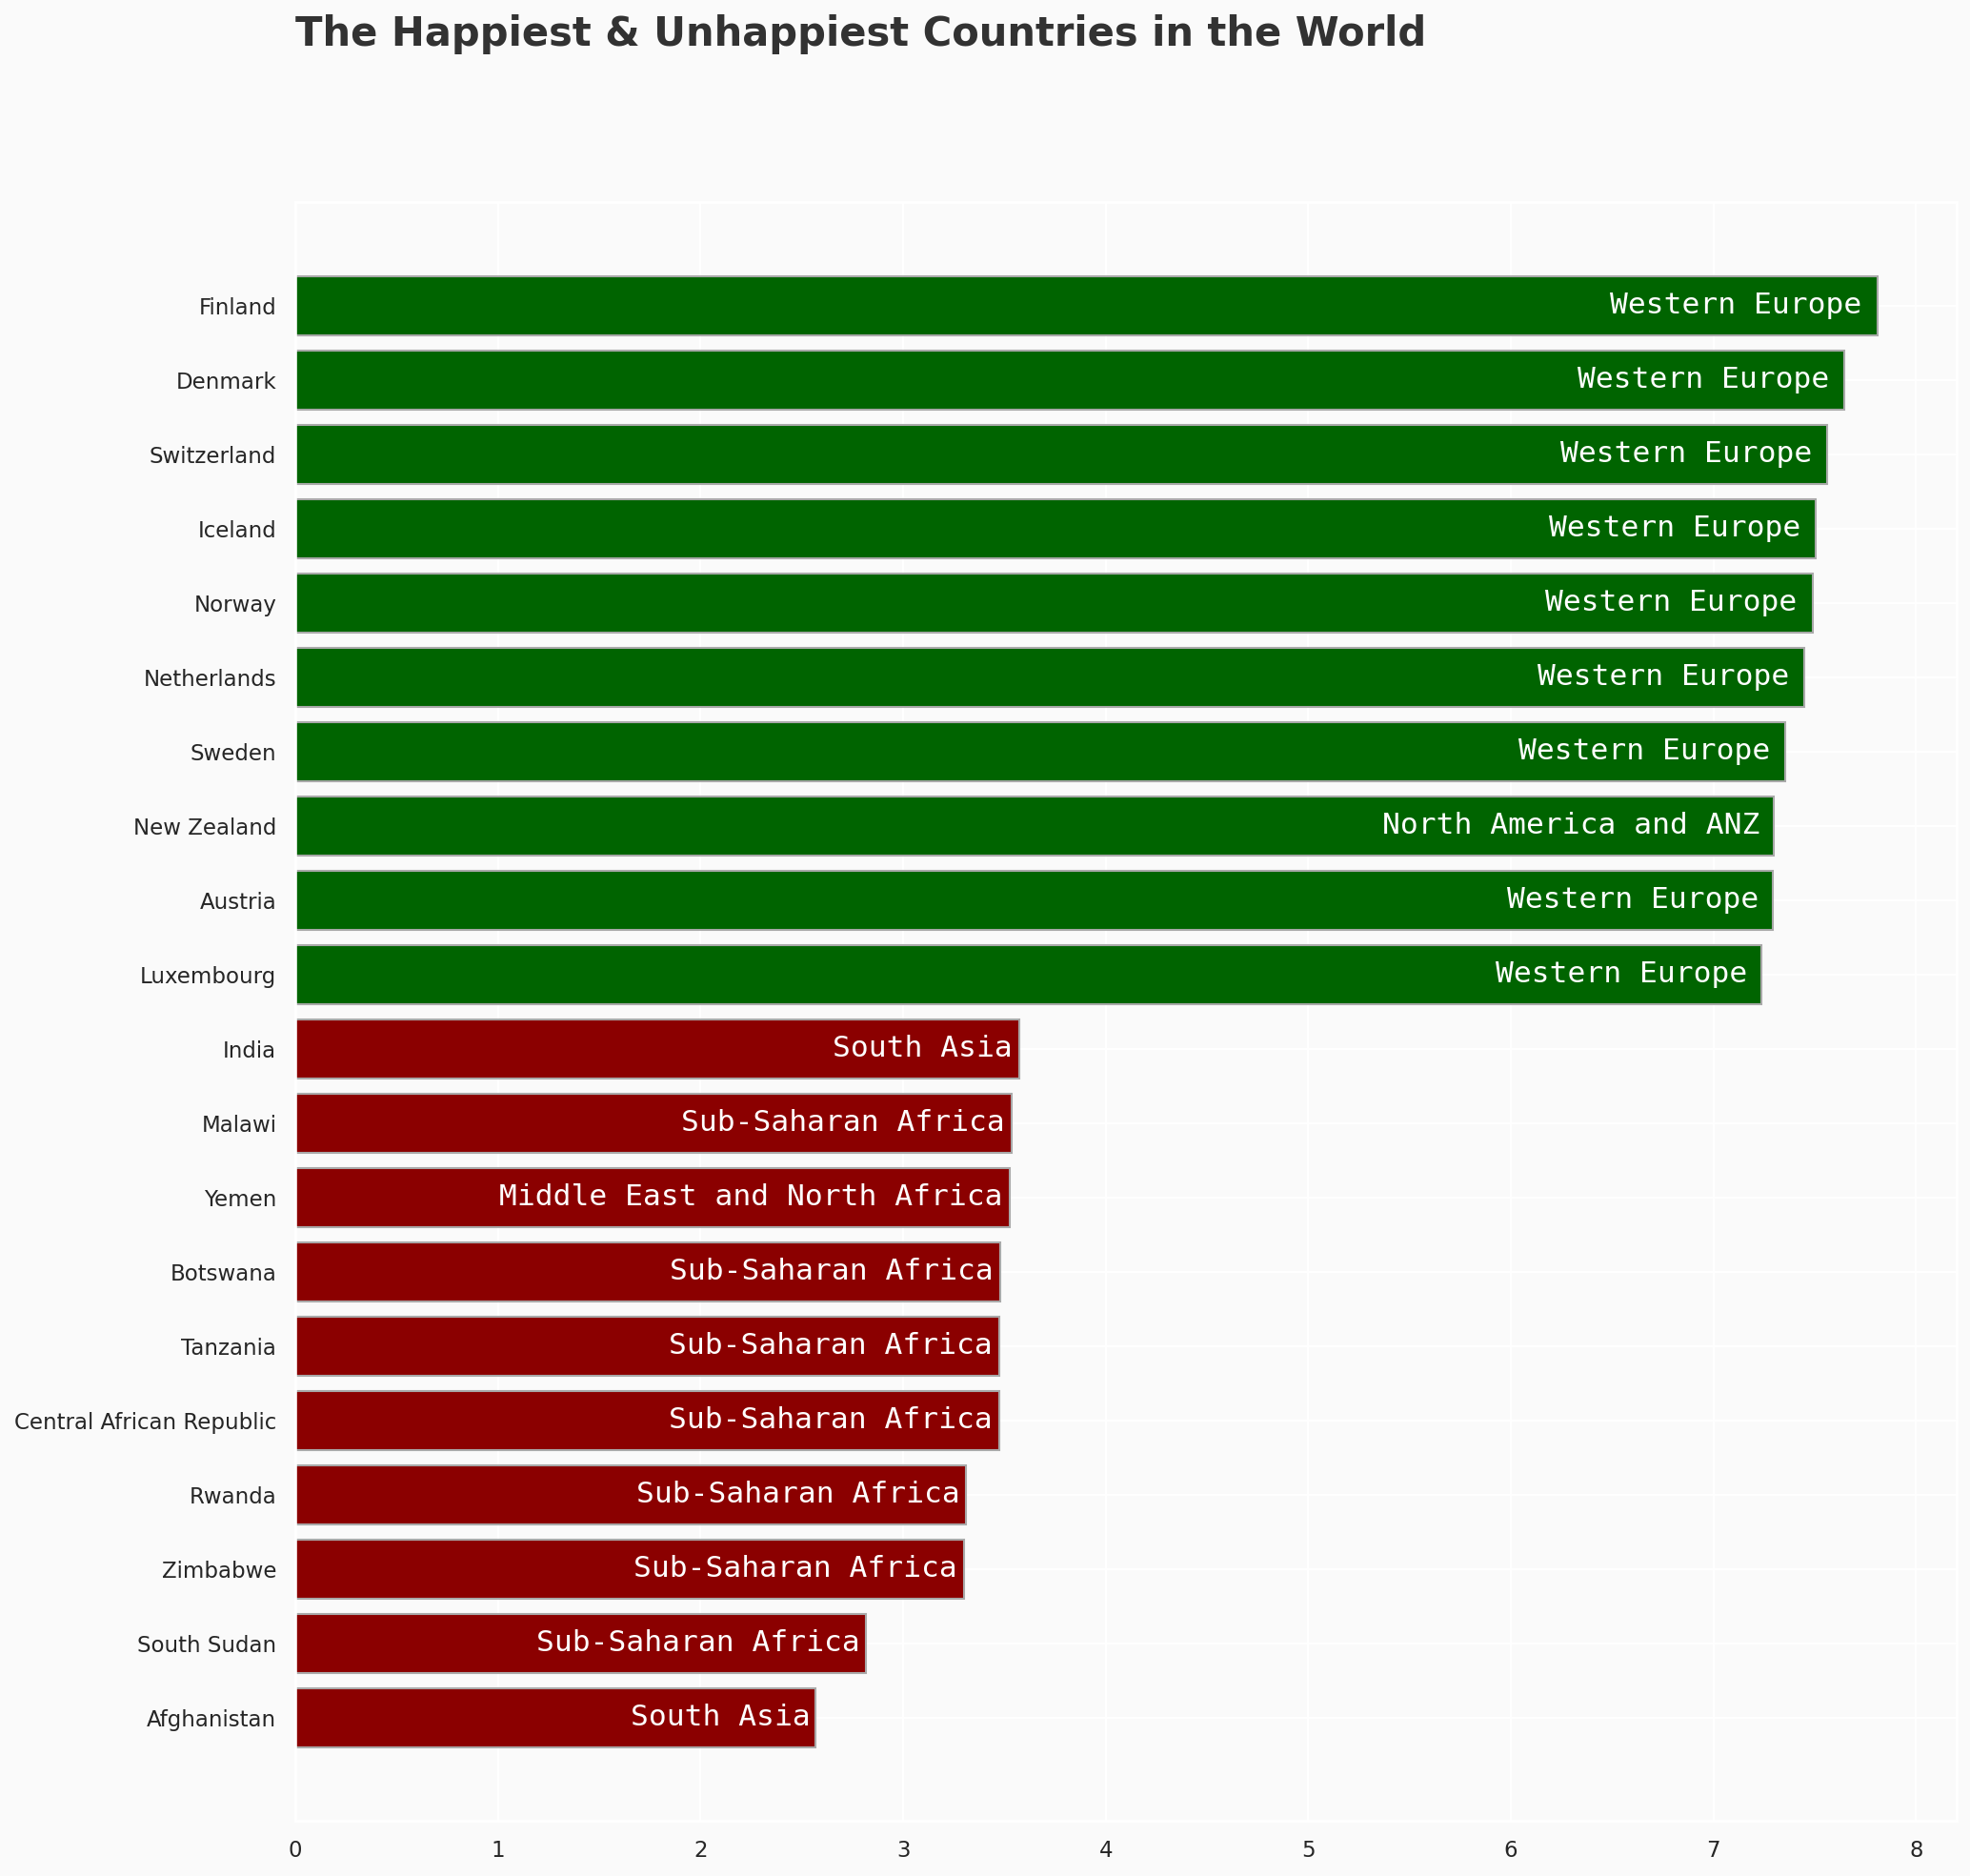

In [51]:
# group top 10 happiest and least happiest
hap = data.groupby('Country')[['Happiness Index', 'Regional Indicator']].max().sort_values('Happiness Index', ascending = False).head(10)
unhap = data.groupby('Country')[['Happiness Index', 'Regional Indicator']].max().sort_values('Happiness Index', ascending = True).head(10)
top_bottom = hap.append(unhap, ignore_index=False).sort_values('Happiness Index', ascending = True)
fig = plt.figure(figsize=(15,15),dpi=150)
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.05, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])

background_color = "#fafafa"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 


# Plots 
# Happiest
data1 = top_bottom['Happiness Index']
color_map = ['red' for _ in range(20)]
for x in range(0,10):
    color_map[x] = 'darkred'      # color highlight
    color_map[x+10] = 'darkgreen'

ax0.barh(data1.index, data1, 
       edgecolor='darkgray',color=color_map)

# diff color text
for i in range(0,20):
    ax0.annotate(list(top_bottom['Regional Indicator'])[i], 
                   xy=(data1[i]-(data1[i]*0.01), i), 
                   va = 'center', ha='right',fontweight='light', fontfamily='monospace',fontsize=15, color='white',rotation=0)
    
ax0.text(0,22.5,'The Happiest & Unhappiest Countries in the World',fontfamily='sans-serif',fontsize=20,fontweight='bold',color='#323232')
plt.show()

Below are box plot and density plot of happiness in each region.

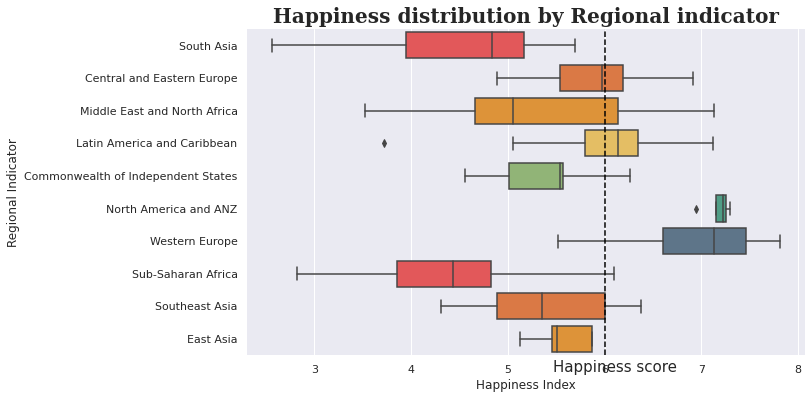

In [52]:
color=["#f94144","#f3722c","#f8961e","#f9c74f","#90be6d","#43aa8b","#577590"]

fig=plt.figure(figsize=(10, 6))
plt.title("Happiness distribution by Regional indicator",family='Serif', weight='bold', size=20)
sns.boxplot(x=data['Happiness Index'],y=data['Regional Indicator'], palette=color)

plt.axvline(6, c='black',ls='--')
plt.text(x=data['Happiness Index'].mean(),y=10,s='Happiness score', size=15)
for s in ['left','right','top','bottom']:
    plt.gca().spines[s].set_visible(False)

If we dive deeper in the happiness score distribution for each region, we can see that all countries in North America and ANZ is greater or equal 7, 90% of countries in Western Europe get the happiness score superior or equal 6 (score equal 6 to above can consider as the high happiness score). It is clear why the two region rank the top highest happiness score. Moreover, in other regions, the happiness score range is quite large, for example, the Middle East and North Africa together with Latin America and Caribbean get the difference 3.6, 3.4 correspondingly between the happiest and the least happiest country. It seems that there is a huge disparity in the level of development of countries in these regions.

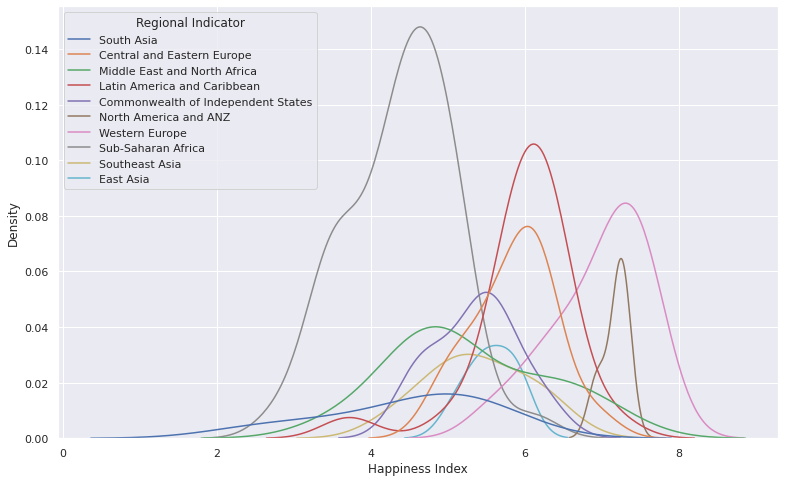

In [53]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
fig.set_size_inches(10, 6)

sns.kdeplot(data= data, x = 'Happiness Index', hue = 'Regional Indicator', ax= ax, legend= True)
plt.show()

### **2.2.1 Hypothesis to test difference of two regions**

In this part, we will use hypothesis testing to detect the differnce of happiness between two region. <br>
$H_0 :$ There is no difference <br>
$H_1 :$ There is difference <br>
<br> Calculate the T-test for the means of two independent samples of scores.

This is a two-sided test for the null hypothesis that 2 independent samples have identical average (expected) values. This test assumes that the populations have identical variances by default. 
<br>We use Scipy library to perform our test.

In [54]:
def hypo_test(reg1,reg2):
    r1 = data[data['Regional Indicator']==reg1]['Happiness Index']
    r2 = data[data['Regional Indicator']==reg2]['Happiness Index']
    t1="Hypotheis test between regions: {} vs {}".format(reg1,reg2)
    stats, p_value= ttest_ind(r1, r2)
    
    if p_value <0.05:
        t2="since p_value : {} is < 0.05, we can reject the Null Hypothesis and say there are significant difference".format(np.round(p_value,3))
    else:
        t2="P_value: {} is >0.05, we can't reject the Null Hypothesis, so we say there is no difference".format(np.round(p_value,3))
    fig=plt.figure(figsize=(15,3))
    plt.title(t1,family='Serif', weight='bold', size=20)
    plt.text(x=plt.xlim()[1]/2,y=plt.ylim()[1]/2,s=t2,ha='center', family='Serif', weight='bold', size=15)
    for pos in ['right','top','bottom','left']:
        plt.gca().spines[pos].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    return

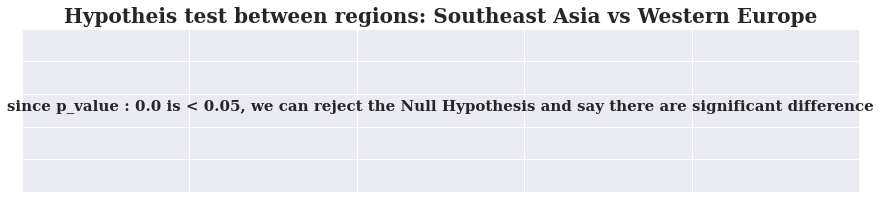

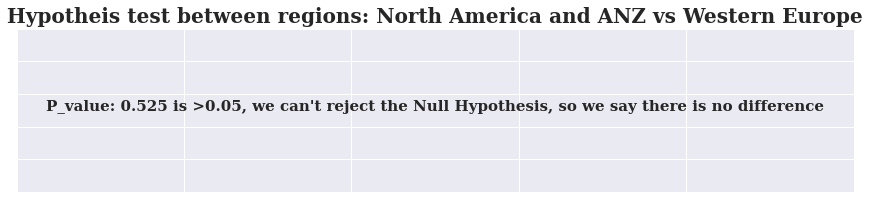

In [55]:
reg = data['Regional Indicator'].unique()
hypo_test(reg[-2],reg[6])
hypo_test(reg[5],reg[6])

The probability to get the countries with happiness index superior than 6.0 in each region as well as the difference between the min and max happiness index.

In [56]:
for region in data['Regional Indicator'].unique():
    print('Region: ', region)
    Region = data[data['Regional Indicator'] == region]
    high = Region[Region['Happiness Index'] >= 6]
    max = Region['Happiness Index'].max()
    print('--The range of happiness score: %.2f'%(Region['Happiness Index'].max() - Region['Happiness Index'].min()))
    print("--There are {} in {} countries in {} that have a happiness score above 6.0 ".format(len(high), len(Region), region))
    print("   => The probability: {0:.2%}%".format(len(high)/len(Region)))

Region:  South Asia
--The range of happiness score: 3.13
--There are 0 in 7 countries in South Asia that have a happiness score above 6.0 
   => The probability: 0.00%%
Region:  Central and Eastern Europe
--The range of happiness score: 2.03
--There are 8 in 16 countries in Central and Eastern Europe that have a happiness score above 6.0 
   => The probability: 50.00%%
Region:  Middle East and North Africa
--The range of happiness score: 3.60
--There are 5 in 16 countries in Middle East and North Africa that have a happiness score above 6.0 
   => The probability: 31.25%%
Region:  Latin America and Caribbean
--The range of happiness score: 3.40
--There are 11 in 21 countries in Latin America and Caribbean that have a happiness score above 6.0 
   => The probability: 52.38%%
Region:  Commonwealth of Independent States
--The range of happiness score: 1.70
--There are 2 in 12 countries in Commonwealth of Independent States that have a happiness score above 6.0 
   => The probability: 16.6

## **2.3 Correlation**

Let's looking for which attributes are related to each other.

In [57]:
corr_pearson = data.corr(method= 'pearson')
corr_spearman = data.corr(method= 'spearman')

mask = np.zeros_like(corr_pearson)
for i in range(mask.shape[0]):
    for j in range(mask.shape[1]):
        if j >= i:
            mask[i, j] = 1

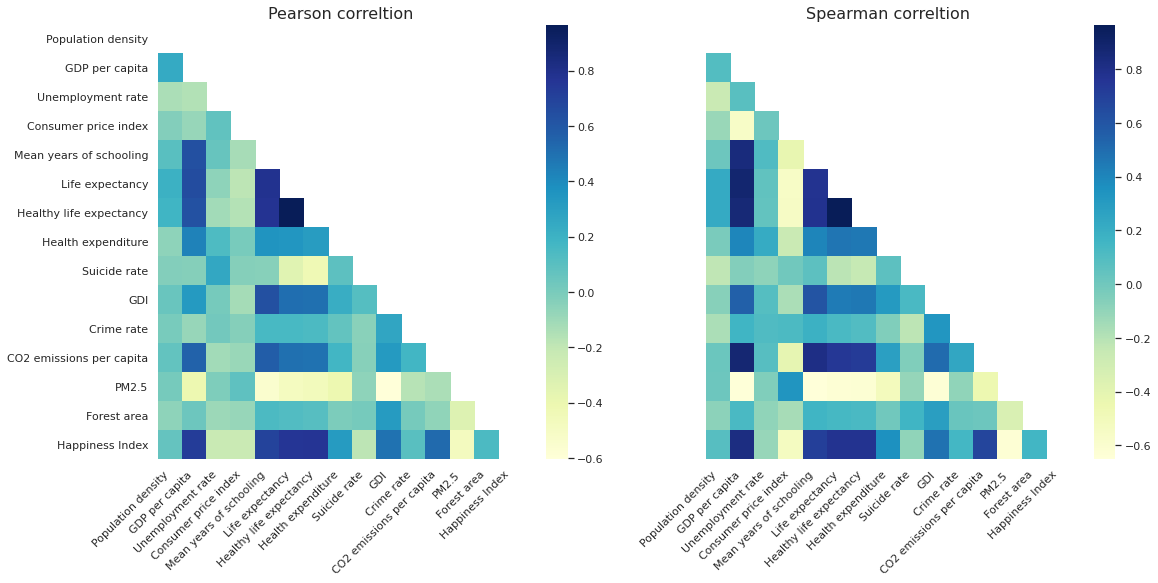

In [58]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(18, 8)

sns.heatmap(corr_pearson, ax = axes[0], cmap="YlGnBu", mask= mask)
axes[0].set_xticklabels(explanatory_name + ['Happiness Index'],
                    rotation=45,
                    horizontalalignment='right')
axes[0].set_yticklabels(explanatory_name + ['Happiness Index'])
axes[0].set_title('Pearson correltion', size = 16)
axes[0].set_facecolor('white')

sns.heatmap(corr_spearman, ax = axes[1], cmap="YlGnBu", mask = mask)
axes[1].set_xticklabels(explanatory_name + ['Happiness Index'],
                    rotation=45,
                    horizontalalignment='right')
axes[1].set_yticklabels([])
axes[1].set_title('Spearman correltion', size= 16)
axes[1].set_facecolor('white')

plt.show()

It is obviously that the data contains some outlier. But they are almost natural, for example, we can see two outliers in population density, and the countries are Singapore and HongKong. So that no need to remove them, except the one that might affects the visulization. <br> 
When visualizing, we find that the Consumer price index of Sount Sudan is an outlier, it is natural because they are having war, but it is too far from others and affects the visualization, so we ignore this.

In [59]:
def iqr_outlier(data, column):
  q1 = data[column].quantile(0.25)
  q3 = data[column].quantile(0.75)
  iqr = q3 - q1
  outlier_condition = (data[column] > q3 + 1.5*iqr) | (data[column] < q1 - 1.5*iqr)
  outlier = data.index[outlier_condition].tolist()
  return outlier

In [60]:
cpi_outlier = data.iloc[123, 5]
data.iloc[123, 5] = float('nan')

We can see that the happiness has high positive correlation with GDP per capita, Mean years of schooling, Life expectancy, Healthy life expectancy and CO2 emission. It also has negative correlation with Consumer price index and PM 2.5. <br>
The Spearman's correlation is quite better in this case compare to Pearson's one. We can see correlation between non-linear related variables.

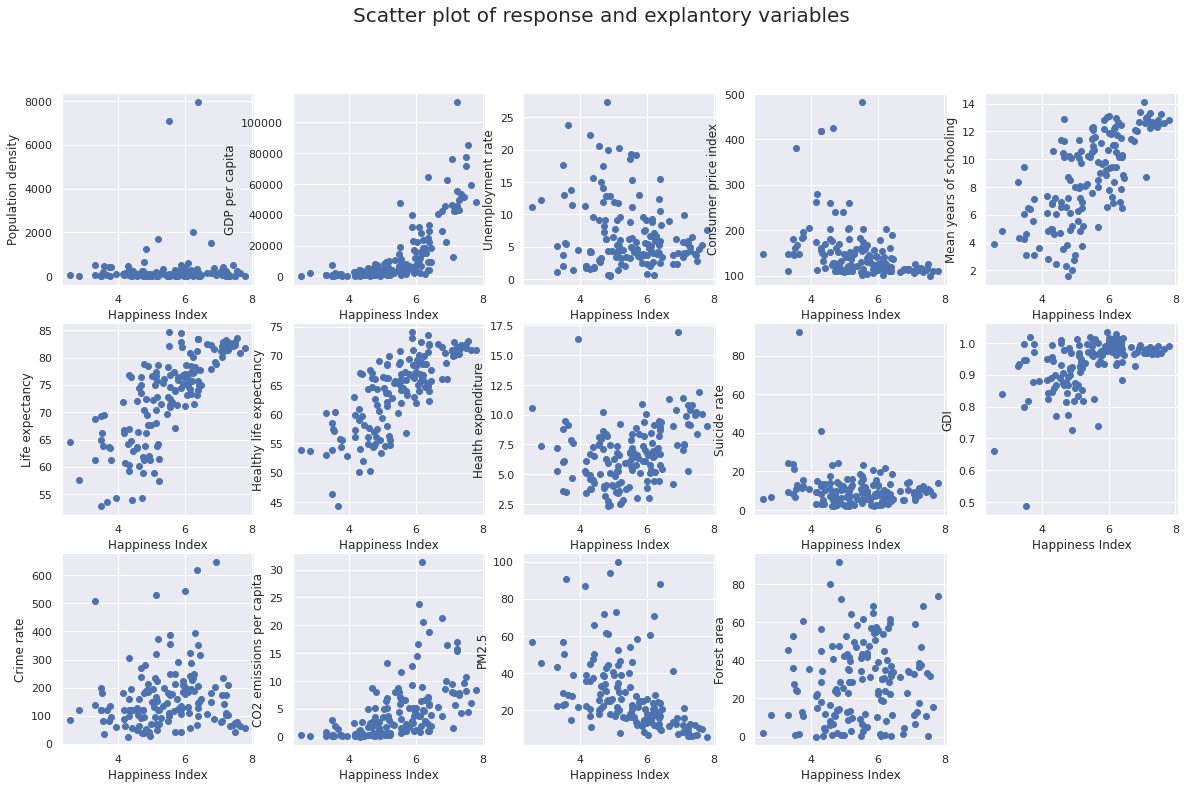

In [61]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(20, 12)
fig.suptitle("Scatter plot of response and explantory variables", size= 20)

for i in range(14):
    axes[i//5, i%5].scatter(data[response_variable], data[explanatory_variables[i]])
    axes[i//5, i%5].set_xlabel(response_variable)
    axes[i//5, i%5].set_ylabel(explanatory_name[i])
axes[2, 4].set_axis_off()

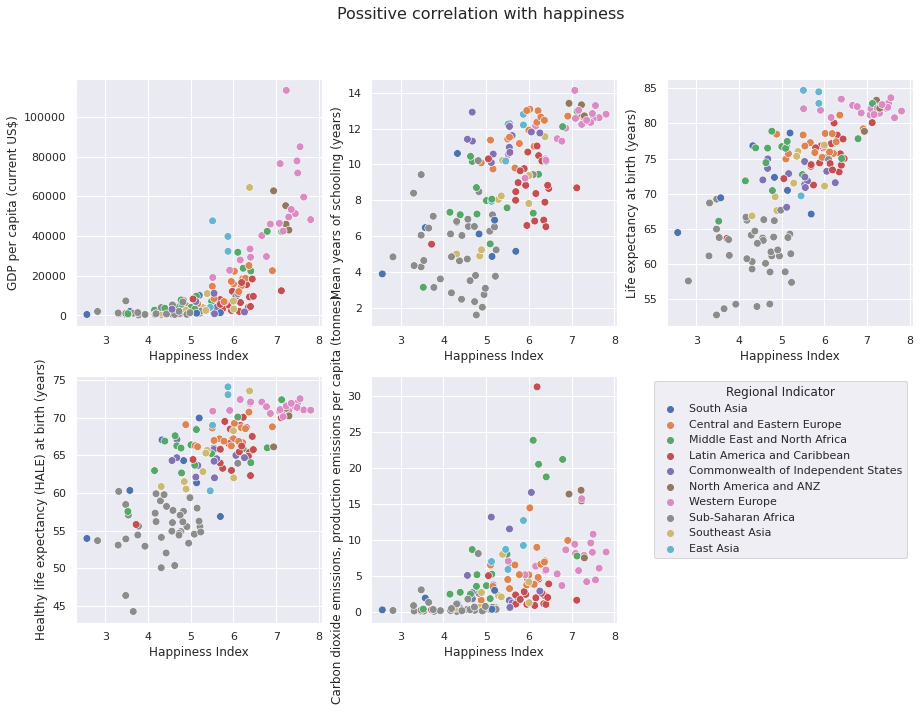

In [62]:
fig, axes = plt.subplots(2, 3)
fig.set_size_inches(15, 10)

high_corr_variable = ['GDP per capita (current US$)',
                      'Mean years of schooling (years)',
                      'Life expectancy at birth (years)',
                      'Healthy life expectancy (HALE) at birth (years)',
                      'Carbon dioxide emissions, production emissions per capita (tonnes)']
for i in range(5):
  sns.scatterplot(data = data, x = 'Happiness Index', y= high_corr_variable[i], hue= 'Regional Indicator',ax = axes[i//3, i%3], legend= False, s= 60)
sns.scatterplot(data= data, x= 'Gender Development Index (GDI)', ax = axes[1, 2], hue = "Regional Indicator")
axes[1, 2].set_axis_off()
fig.suptitle("Possitive correlation with happiness", size = 16)

plt.show()

Above is the scatter plot of happiness with explanatory variables having positive correlation with it. 

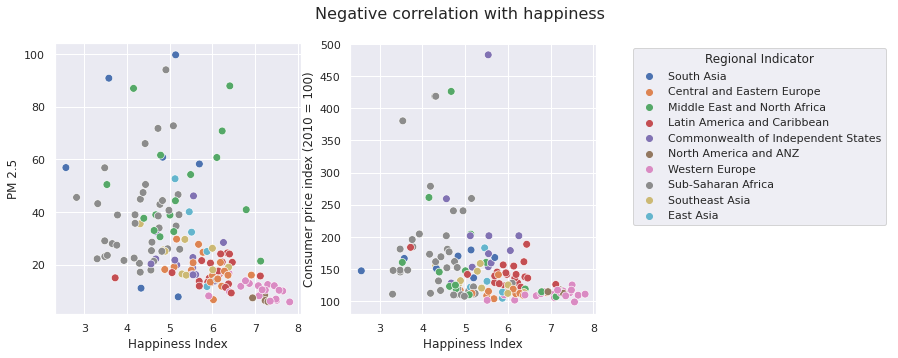

In [63]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(15, 5)

neg_corr_variable = ['PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
                     'Consumer price index (2010 = 100)']
axes[0].set_ylabel("PM 2.5")
for i in range(2):
  sns.scatterplot(data = data, x = 'Happiness Index', y= neg_corr_variable[i], hue='Regional Indicator', ax = axes[i], legend= False, s=60)
sns.scatterplot(data= data, x = 'Gender Development Index (GDI)', hue = "Regional Indicator", ax = axes[2])
axes[2].set_axis_off()
fig.suptitle("Negative correlation with happiness", size = 16)

plt.show()

# **3. Visualization**

## **3.1 Parallel coordinates plot** <br>
We use Plotly library for parallel coordinate plot. Axes in plot are arranged from negatively correlated to positively correlated with Happiness. The last axis is Happiness and we color lines based on happiness value, red means high and green means low happiness.

In [64]:
import plotly.express as px

px.parallel_coordinates(data[['Consumer price index (2010 = 100)',
                              'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)',
                              'GDP per capita (current US$)',
                              'Mean years of schooling (years)',
                              'Life expectancy at birth (years)',
                              'Healthy life expectancy (HALE) at birth (years)',
                              'Happiness Index'
                              ]], 
                        labels= {'Consumer price index (2010 = 100)': 'Consumer price index',
                                'PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)': 'PM 2.5',
                                'GDP per capita (US dollars)': 'GDP per capita',
                                'Mean years of schooling (years)': 'Mean years of schooling',
                                'Life expectancy at birth (years)' : 'Life expectacy at birth',
                                'Healthy life expectancy (HALE) at birth (years)': 'Healthy life expectancy',
                                'Happiness Index': 'Happiness'},
                        color= 'Happiness Index',
                        title= {'text': 'Parallel coordinate plot of Happiness and correlated variables',
                                'y': 0.95,
                                'x': 0.5},
                        color_continuous_scale=px.colors.diverging.Tealrose)

Restore the consumer price index of South Sudan.

In [65]:
data.iloc[123, 5] = cpi_outlier

## **3.2 PCA and Clustering** <br>

### **3.2.1 Two dimensions**

We need to scale data to normal distribution. The difference in range of variables might affect visualization. After scaling the data, we use PCA class of Scikit-Learn library to reduce dimensions.

In [66]:
t = data.drop(['Country','Regional Indicator','Happiness Index'],axis=1)
scaler = StandardScaler()               #scale to normal distribution
scaled_t = scaler.fit_transform(t)      #fit data
scaled = pd.DataFrame(scaled_t)         #convert to dataframe

After scaling the data, we use PCA class of Scikit-Learn library to reduce dimensions.

In [67]:
pca = PCA(n_components=2)               #call dimensions-reducing object  
pca.fit(scaled)                         #fit to data
new = pca.transform(scaled)             #tranform data to n dimensions
new = pd.DataFrame(new)         

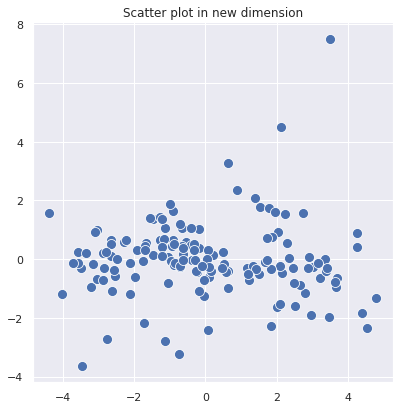

In [68]:
fig = plt.figure()
fig.set_size_inches(5, 5)
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title("Scatter plot in new dimension")

sns.set(rc={'figure.figsize':(12.5,10)})
sns.scatterplot(data=new,x=0,y=1,legend=False,s=100, ax= ax)       # plot data in new space
ax.set_xlabel(None)
ax.set_ylabel(None)

plt.show()

In [69]:
 kmeans_kwargs = {                   #parameters for KMeans clustering agorithms
     "init": "random",
     "n_init": 10,
     "max_iter": 300,
     "random_state": 42,
}

sse = []                            #list of sum of square errors
silhouette_coefficients = []
for k in range(2, 15):              #number of clusters value range
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)      #KMeans clustering object
    kmeans.fit(scaled)                                  #fit to data
    sse.append(kmeans.inertia_)            
    score = silhouette_score(scaled, kmeans.labels_)
    silhouette_coefficients.append(score)            

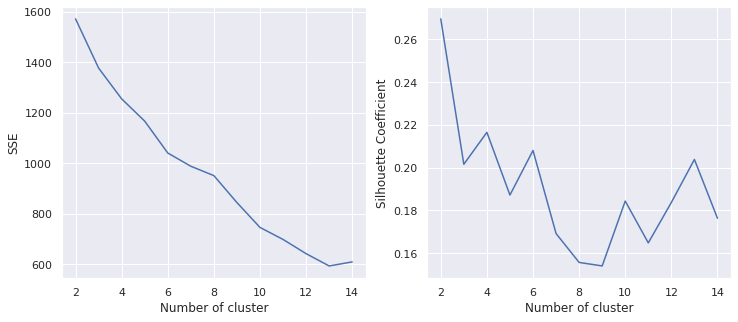

In [70]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axes[0].plot(range(2, 15), sse)
axes[0].set_xlabel("Number of cluster")
axes[0].set_ylabel("SSE")

axes[1].plot(range(2, 15), silhouette_coefficients)
axes[1].set_xlabel("Number of cluster")
axes[1].set_ylabel("Silhouette Coefficient")

plt.show()

SSE will most likely decrease if number of clusters increase, error will be 0 when the number of clusters equal to the number of samples (in this case is number of countries). <br>
Silhouette coefficient is a measure of cluster cohesion and separation. It quantifies how well a data point fits into its assigned cluster based on two factors:
1.	How close the data point is to other points in the cluster
2.	How far away the data point is from points in other clusters

The graph indicates that 4 is a suitable number of clusters

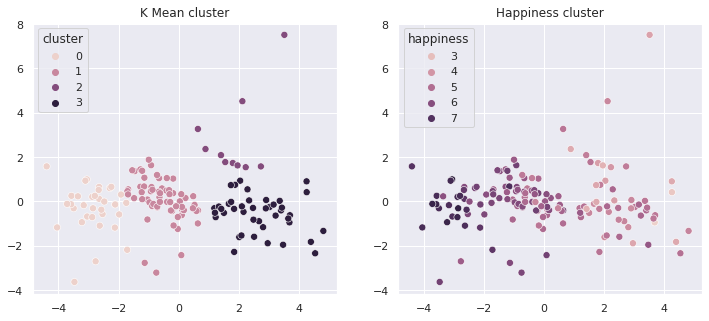

In [71]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

#lot new data labeled to n clusters
kmeans = KMeans(n_clusters= 4)                        
label = kmeans.fit_predict(new)
new.insert(0,'cluster',label,True)
sns.scatterplot(data=new, x=0, y=1, hue='cluster',s=50, ax = axes[0]) 

new.insert(0,'happiness',data['Happiness Index'],True)            #plot new data in term of Happiness
sns.scatterplot(data=new,x=0,y=1,hue='happiness',s=50, ax = axes[1]) 

axes[0].set_xlabel(None)
axes[1].set_xlabel(None)
axes[0].set_ylabel(None)
axes[1].set_ylabel(None)
axes[0].set_title("K Mean cluster")
axes[1].set_title("Happiness cluster")

plt.show()

Clustering algorithm may find hidden similarities that can not be seen visually.

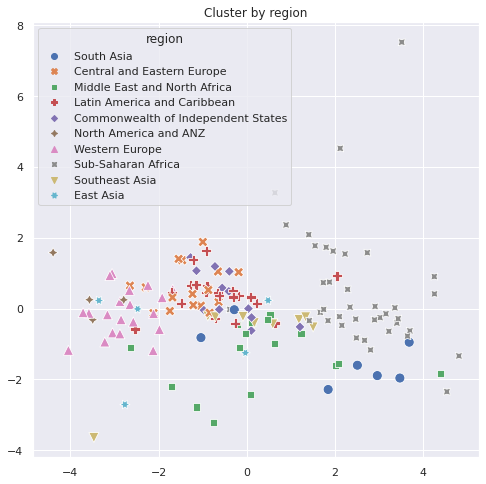

In [72]:
#plot new data in term of regions
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(8, 8)

new.insert(0,'region',data['Regional Indicator'],True) 
sns.scatterplot(data=new,x=0,y=1,hue='region',style='region',s=100, ax = axes) 
axes.set_xlabel(None)
axes.set_ylabel(None)
axes.set_title("Cluster by region")

plt.show()

The clustering algorithm indicates that countries in the different regions might have close relation and countries in the same region could also differ from each other in some ways. <br>
Visually, we can olyy see three clusters, the first contain mostly countries with happiness index over 6, the second with averagely happy countries and the third clusters of happiness under 4 countries.

The clusters predicted also match the happiness closely, this means that similar countries might have similar happiness indexes.


### **3.2.2 Three dimensions** <br>

For visualization, human's brain can not be able to see more than three dimensions. So we will try to reduce to 3-dimension space, and compare with the two-dimension.

In [73]:
#Try PCA to 3 dimensions for reference
pca = PCA(n_components=3)               #call dimensions-reducing object  
pca.fit(scaled)      
new = pca.transform(scaled)             #tranform data to n dimensions
new = pd.DataFrame(new)     

In [74]:
new.insert(0,'happiness',data['Happiness Index'])

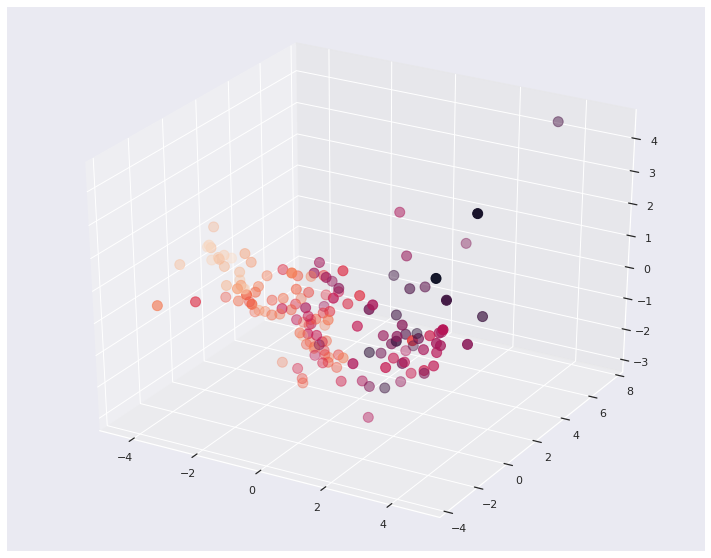

In [75]:
ax = plt.axes(projection='3d')
ax.scatter3D(new[0], new[1], new[2],c=new['happiness'],s=100)

plt.show()

Quite hard to see. Let's project to 3 axes space. 

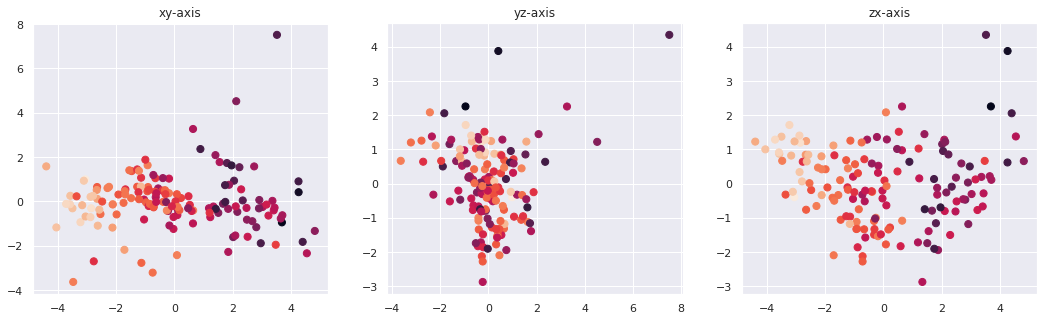

In [76]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 5)

axes[0].scatter(new[0],new[1],c=new['happiness'],s=50)
axes[1].scatter(new[1],new[2],c=new['happiness'],s=50)
axes[2].scatter(new[0],new[2],c=new['happiness'],s=50)

axes[0].set_title("xy-axis")
axes[1].set_title("yz-axis")
axes[2].set_title("zx-axis")

plt.show()

In conclusion, 2d PCA is better than 3d PCA at least for our project.